In [49]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
from dynaconf import Dynaconf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.inspection import PartialDependenceDisplay
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import matplotlib.pyplot as plt
import seaborn as sns
import math
import shap

import joblib

In [50]:
#Load matchup_feature data
settings = Dynaconf(envvar_prefix='MYAPP', load_dotenv=True)
DB_URL = settings.DB_ENGINE_URL

engine = create_engine(DB_URL)

with engine.begin() as conn:
    matchup_df = pd.read_sql('SELECT * FROM matchup_features', conn)

In [51]:
#Clean/Explore
matchup_df.head()

,game_id,season,week,elo_diff,points_per_game_diff,points_allowed_per_game_diff,recent_points_per_game_diff,recent_points_allowed_per_game_diff,margin_of_victory_diff,win_rate_diff,...,yards_allowed_per_play_diff,explosiveness_diff,success_rate_diff,travel_distance,rest_days_diff,recent_form_diff,neutral_site,vegas_spread_close,vegas_over_under_close,home_win
0,400603827,2015,1,28.86,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,687.645,-9.223370e+18,NaN,1,-12.0,44.0,1
1,400603828,2015,1,29.71,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,767.009,-9.223370e+18,NaN,0,-32.5,49.5,1
2,400603829,2015,1,19.42,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,386.583,-9.223370e+18,NaN,1,-10.5,54.0,1
3,400603830,2015,1,20.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1456.180,-9.223370e+18,NaN,0,-34.0,54.0,1
4,400603831,2015,1,29.71,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,512.644,-9.223370e+18,NaN,0,-35.0,57.0,1


In [52]:
matchup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7528 entries, 0 to 7527
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   game_id                              7528 non-null   int64  
 1   season                               7528 non-null   int64  
 2   week                                 7528 non-null   int64  
 3   elo_diff                             7528 non-null   float64
 4   points_per_game_diff                 6486 non-null   float64
 5   points_allowed_per_game_diff         6486 non-null   float64
 6   recent_points_per_game_diff          6486 non-null   float64
 7   recent_points_allowed_per_game_diff  6486 non-null   float64
 8   margin_of_victory_diff               6486 non-null   float64
 9   win_rate_diff                        6486 non-null   float64
 10  yards_per_play_diff                  6385 non-null   float64
 11  yards_allowed_per_play_diff   

In [53]:
matchup_df.describe()

,game_id,season,week,elo_diff,points_per_game_diff,points_allowed_per_game_diff,recent_points_per_game_diff,recent_points_allowed_per_game_diff,margin_of_victory_diff,win_rate_diff,...,yards_allowed_per_play_diff,explosiveness_diff,success_rate_diff,travel_distance,rest_days_diff,recent_form_diff,neutral_site,vegas_spread_close,vegas_over_under_close,home_win
count,7.528000e+03,7528.000000,7528.000000,7528.000000,6486.00000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,...,6385.000000,6385.000000,6385.000000,7528.000000,7.528000e+03,6486.000000,7528.000000,7497.000000,7455.000000,7528.000000
mean,4.011835e+08,2019.529357,7.302604,9.459536,0.06875,-0.345576,-0.124422,-0.220655,0.414325,0.005406,...,-0.026421,-0.000982,0.001450,591.310917,-1.276623e+18,-0.000694,0.079304,-4.166800,55.207243,0.580101
std,2.829287e+05,2.918437,4.101196,127.823593,11.54263,11.593649,13.574128,13.545679,18.015006,0.391538,...,0.987351,0.188667,0.076044,535.862520,3.185398e+18,0.471636,0.270230,13.906213,8.264654,0.493575
min,4.006038e+08,2015.000000,1.000000,-519.580000,-51.00000,-63.000000,-51.833300,-63.000000,-85.000000,-1.000000,...,-4.541810,-1.311670,-0.331206,2.562420,-9.223370e+18,-1.000000,0.000000,-54.500000,27.500000,0.000000
25%,4.009375e+08,2017.000000,4.000000,-70.387500,-7.50000,-7.650760,-9.333330,-9.000000,-11.314550,-0.250000,...,-0.628090,-0.112911,-0.046229,245.689000,-4.320000e+14,-0.333333,0.000000,-13.000000,49.000000,0.000000
50%,4.011220e+08,2019.000000,7.000000,8.830000,0.00000,-0.250000,0.000000,-0.333333,0.166667,0.000000,...,-0.023481,0.000964,0.001662,448.501500,0.000000e+00,0.000000,0.000000,-3.500000,55.000000,1.000000
75%,4.014156e+08,2022.000000,11.000000,89.477500,7.66667,7.250000,9.000000,9.000000,11.735100,0.263636,...,0.596697,0.112196,0.049128,763.997000,0.000000e+00,0.333333,0.000000,5.000000,60.500000,1.000000
max,4.017299e+08,2024.000000,16.000000,567.320000,49.00000,53.333300,49.000000,53.333300,90.000000,1.000000,...,6.387010,1.099930,0.320819,5014.590000,1.088640e+16,1.000000,1.000000,54.000000,90.000000,1.000000


In [54]:
#Missing Values
matchup_df.isnull().sum()

game_id                                   0
season                                    0
week                                      0
elo_diff                                  0
points_per_game_diff                   1042
points_allowed_per_game_diff           1042
recent_points_per_game_diff            1042
recent_points_allowed_per_game_diff    1042
margin_of_victory_diff                 1042
win_rate_diff                          1042
yards_per_play_diff                    1143
yards_allowed_per_play_diff            1143
explosiveness_diff                     1143
success_rate_diff                      1143
travel_distance                           0
rest_days_diff                            0
recent_form_diff                       1042
neutral_site                              0
vegas_spread_close                       31
vegas_over_under_close                   73
home_win                                  0
dtype: int64

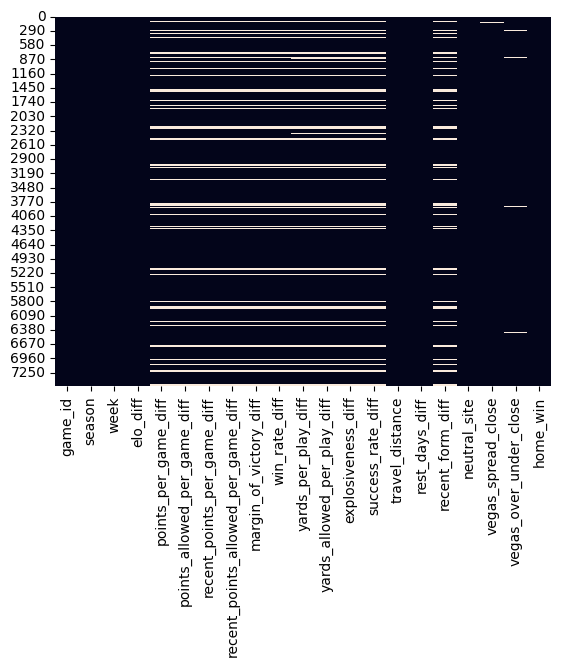

In [55]:
sns.heatmap(matchup_df.isnull(), cbar=False)
plt.show()

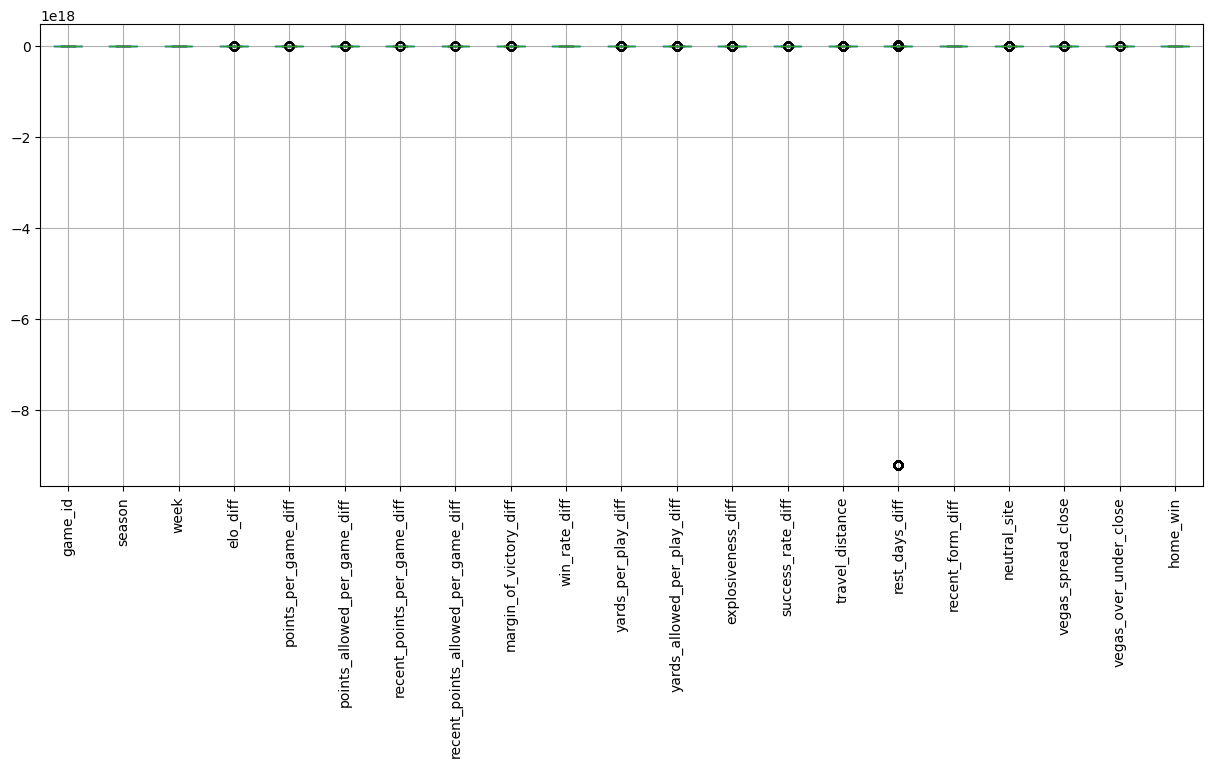

In [56]:
#Outlier detection
matchup_df.boxplot(figsize=(15,6))
plt.xticks(rotation=90)
plt.show()

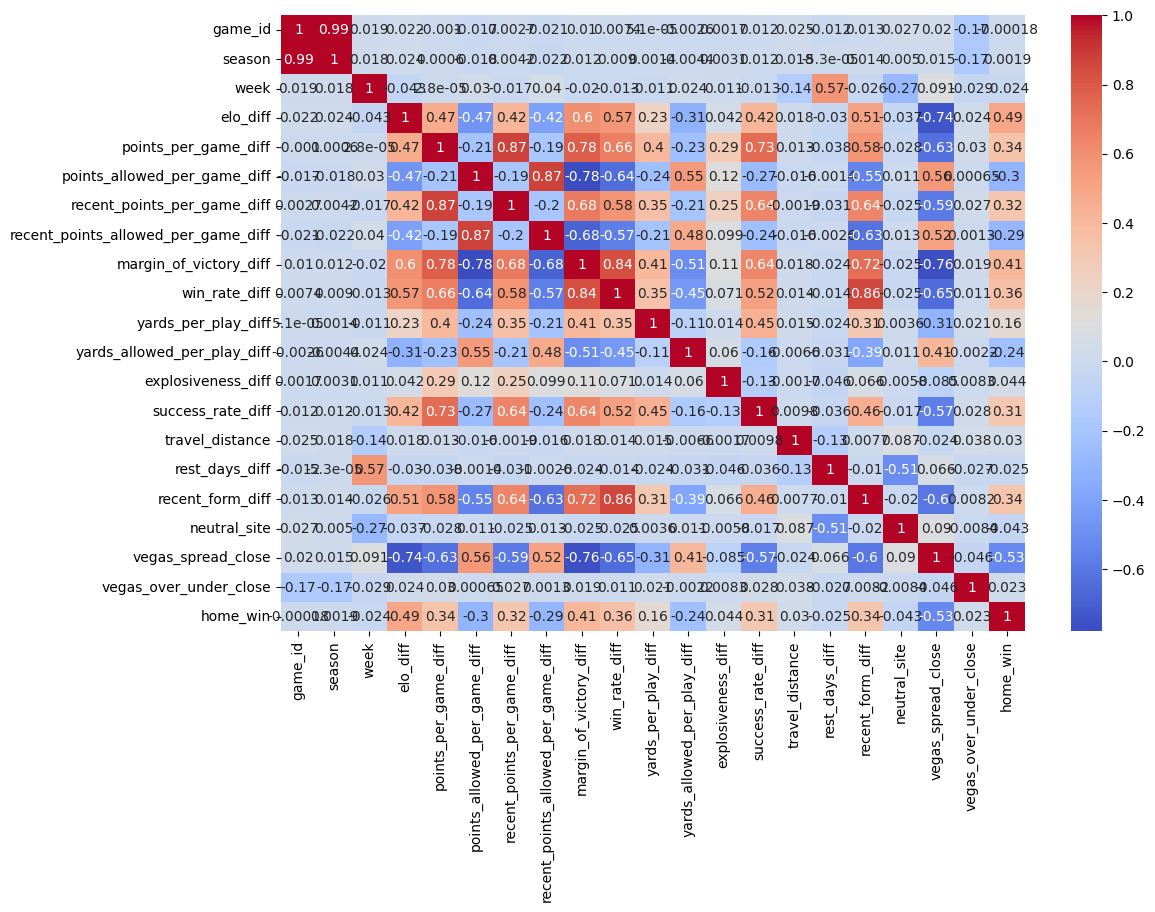

In [57]:
#Correlation analysis
corr = matchup_df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

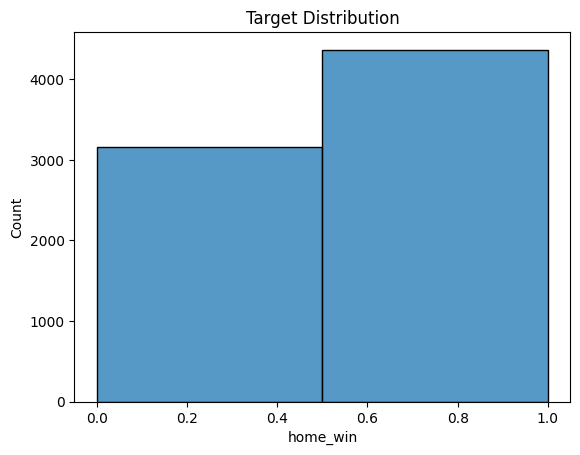

In [58]:
#Target Variable Distribution
sns.histplot(matchup_df['home_win'].astype(float), bins=2)
plt.title('Target Distribution')
plt.show()

In [59]:
#Check how many games were played at neutral sites
print(matchup_df[matchup_df['neutral_site'] == 1].shape[0])

597


In [60]:
#Since those games will have erroneous travel distances, drop those games
matchup_df = matchup_df[matchup_df['neutral_site'] == 0]
matchup_df = matchup_df.drop(columns=['neutral_site'])

In [61]:
#Drop rows with missing values
matchup_df = matchup_df.dropna()

In [62]:
#Define features and target
X = matchup_df.drop(columns=['home_win', 'game_id', 'season', 'week']).copy()
y = matchup_df['home_win'].astype(float).copy()

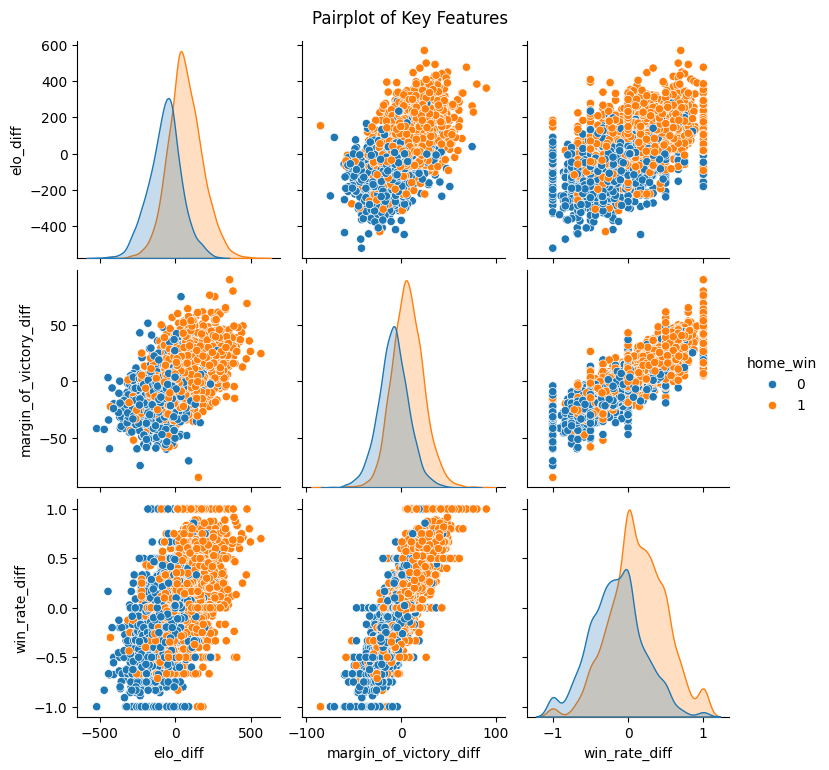

In [63]:
# Pairplot for selected features and target
selected_cols = ['elo_diff', 'margin_of_victory_diff', 'win_rate_diff', 'home_win']
sns.pairplot(matchup_df[selected_cols], hue='home_win', diag_kind='kde')
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

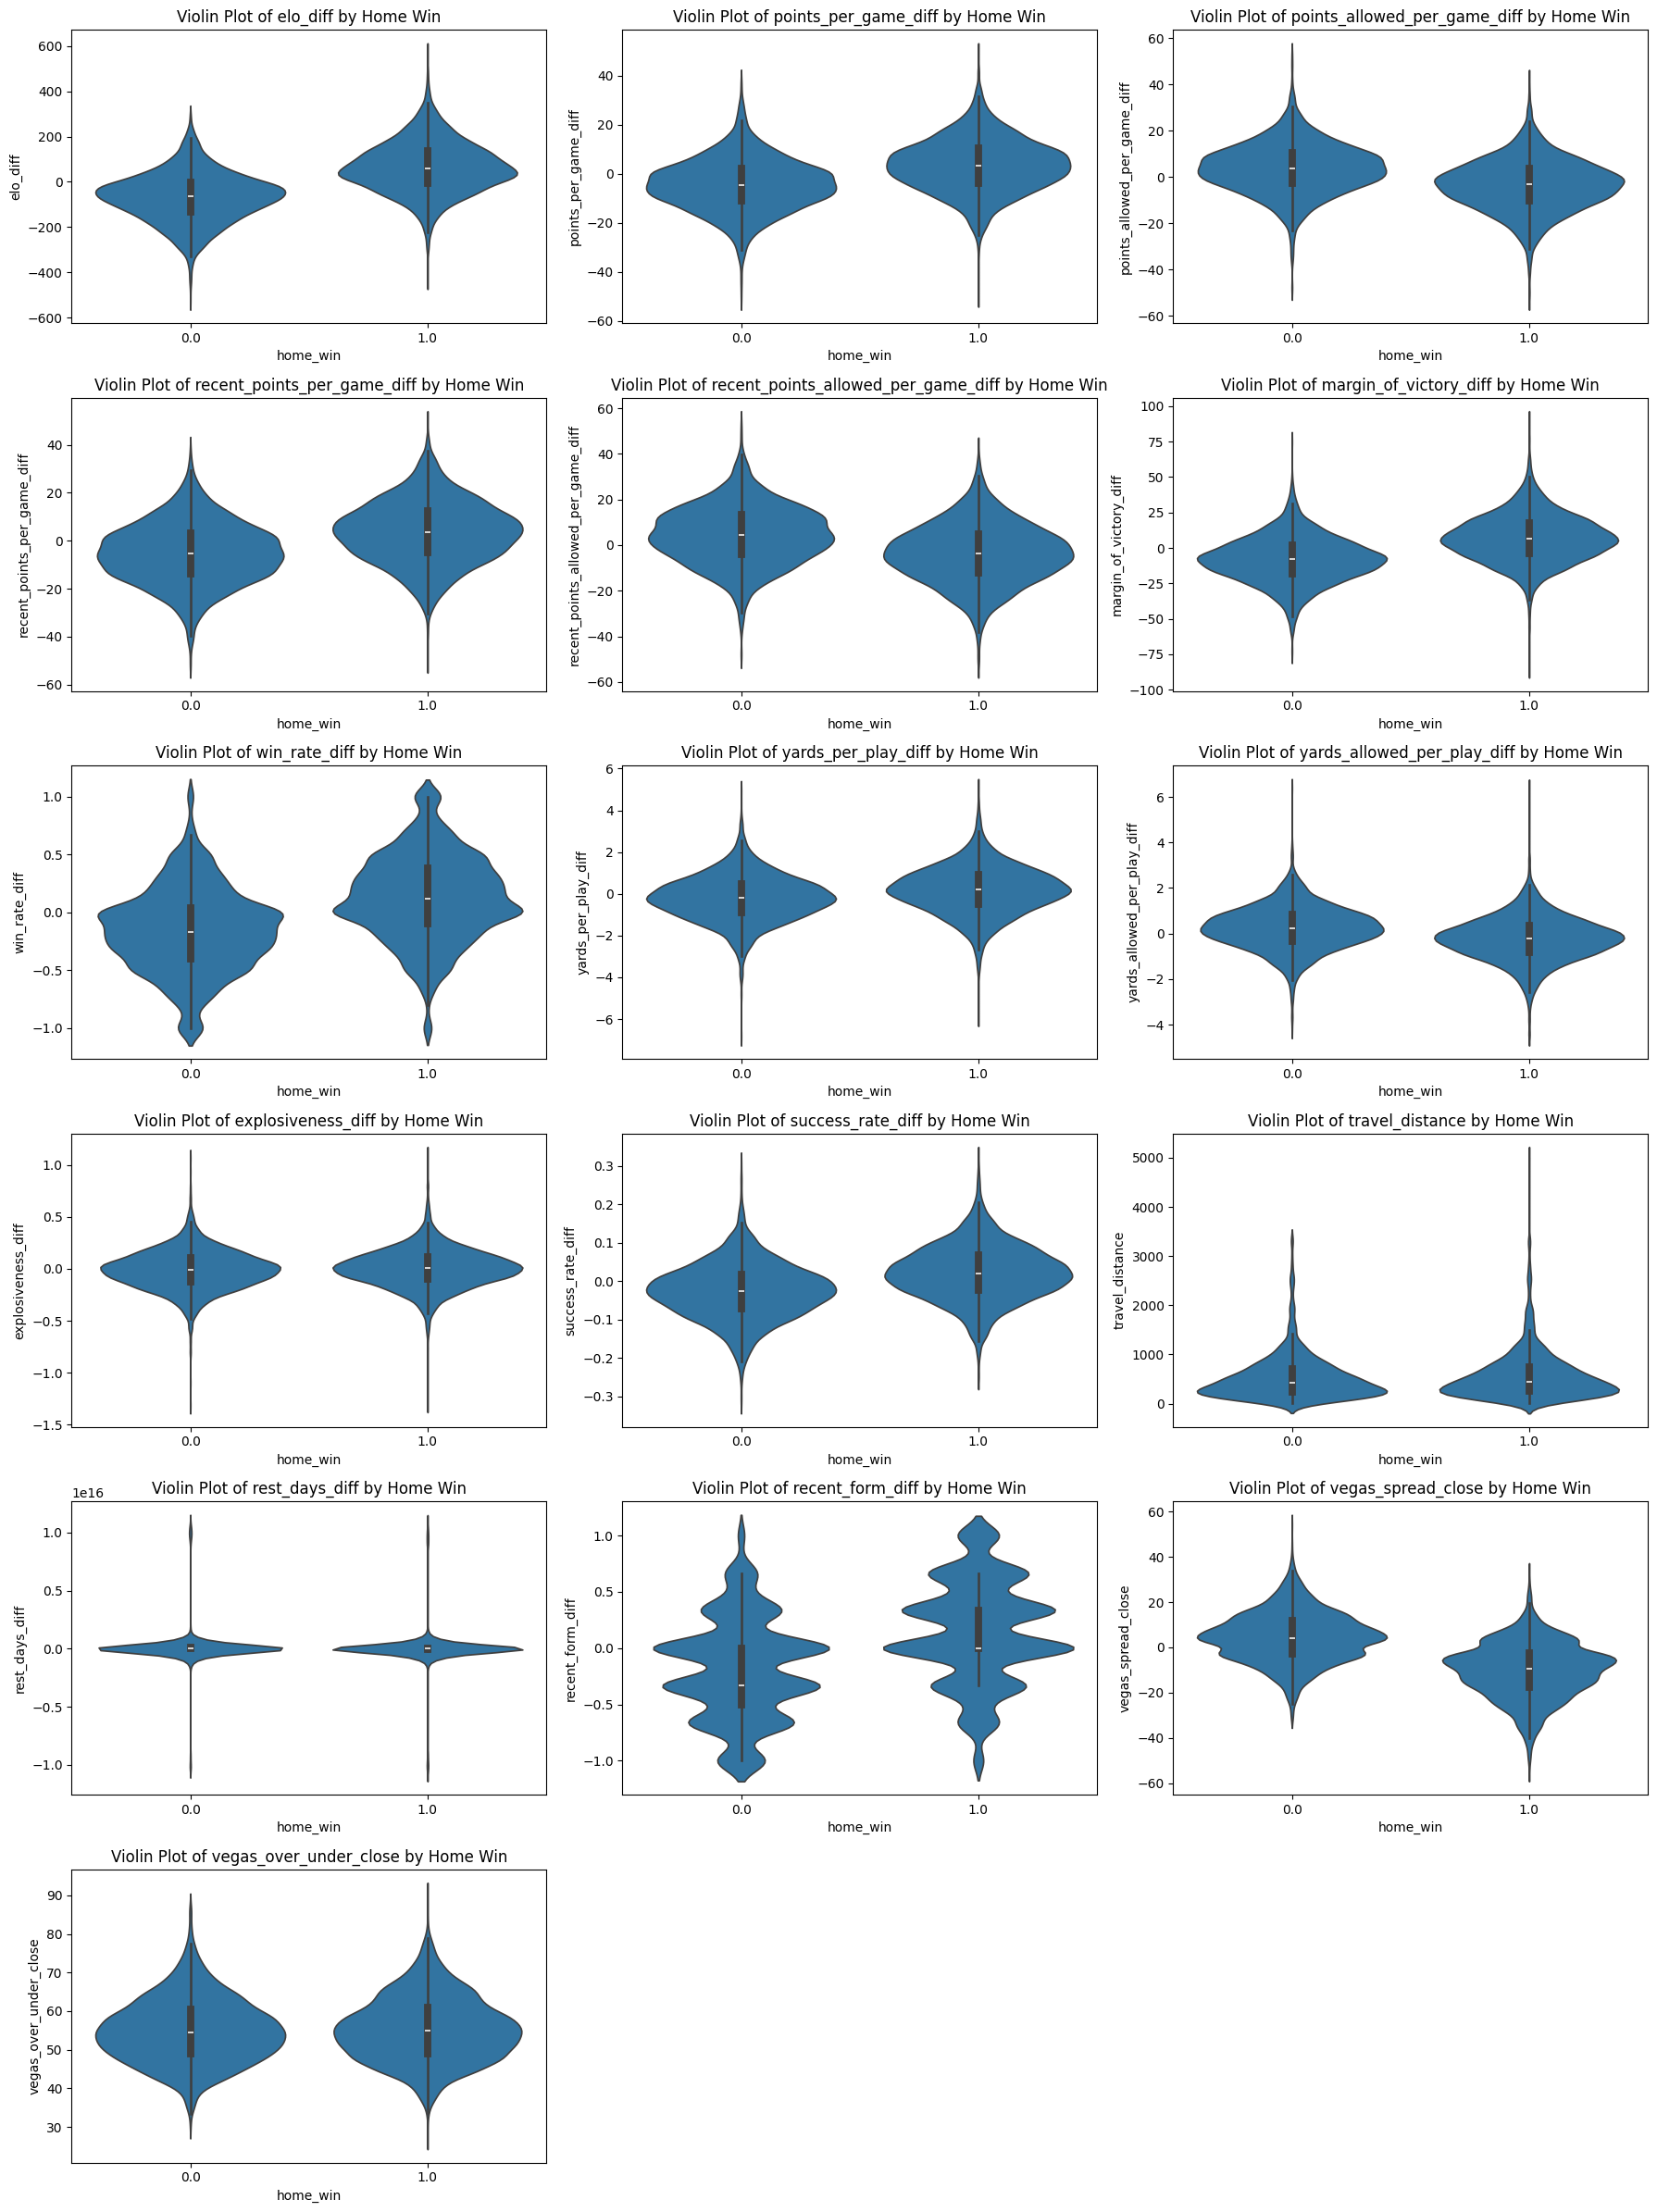

In [64]:
# Violin plots for feature distributions by target
num_features = len(X.columns)
cols = 3  # Number of columns in the grid
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for idx, col in enumerate(X.columns):
    sns.violinplot(x=y, y=X[col], ax=axes[idx])
    axes[idx].set_title(f'Violin Plot of {col} by Home Win')

# Hide any unused subplots
for idx in range(num_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

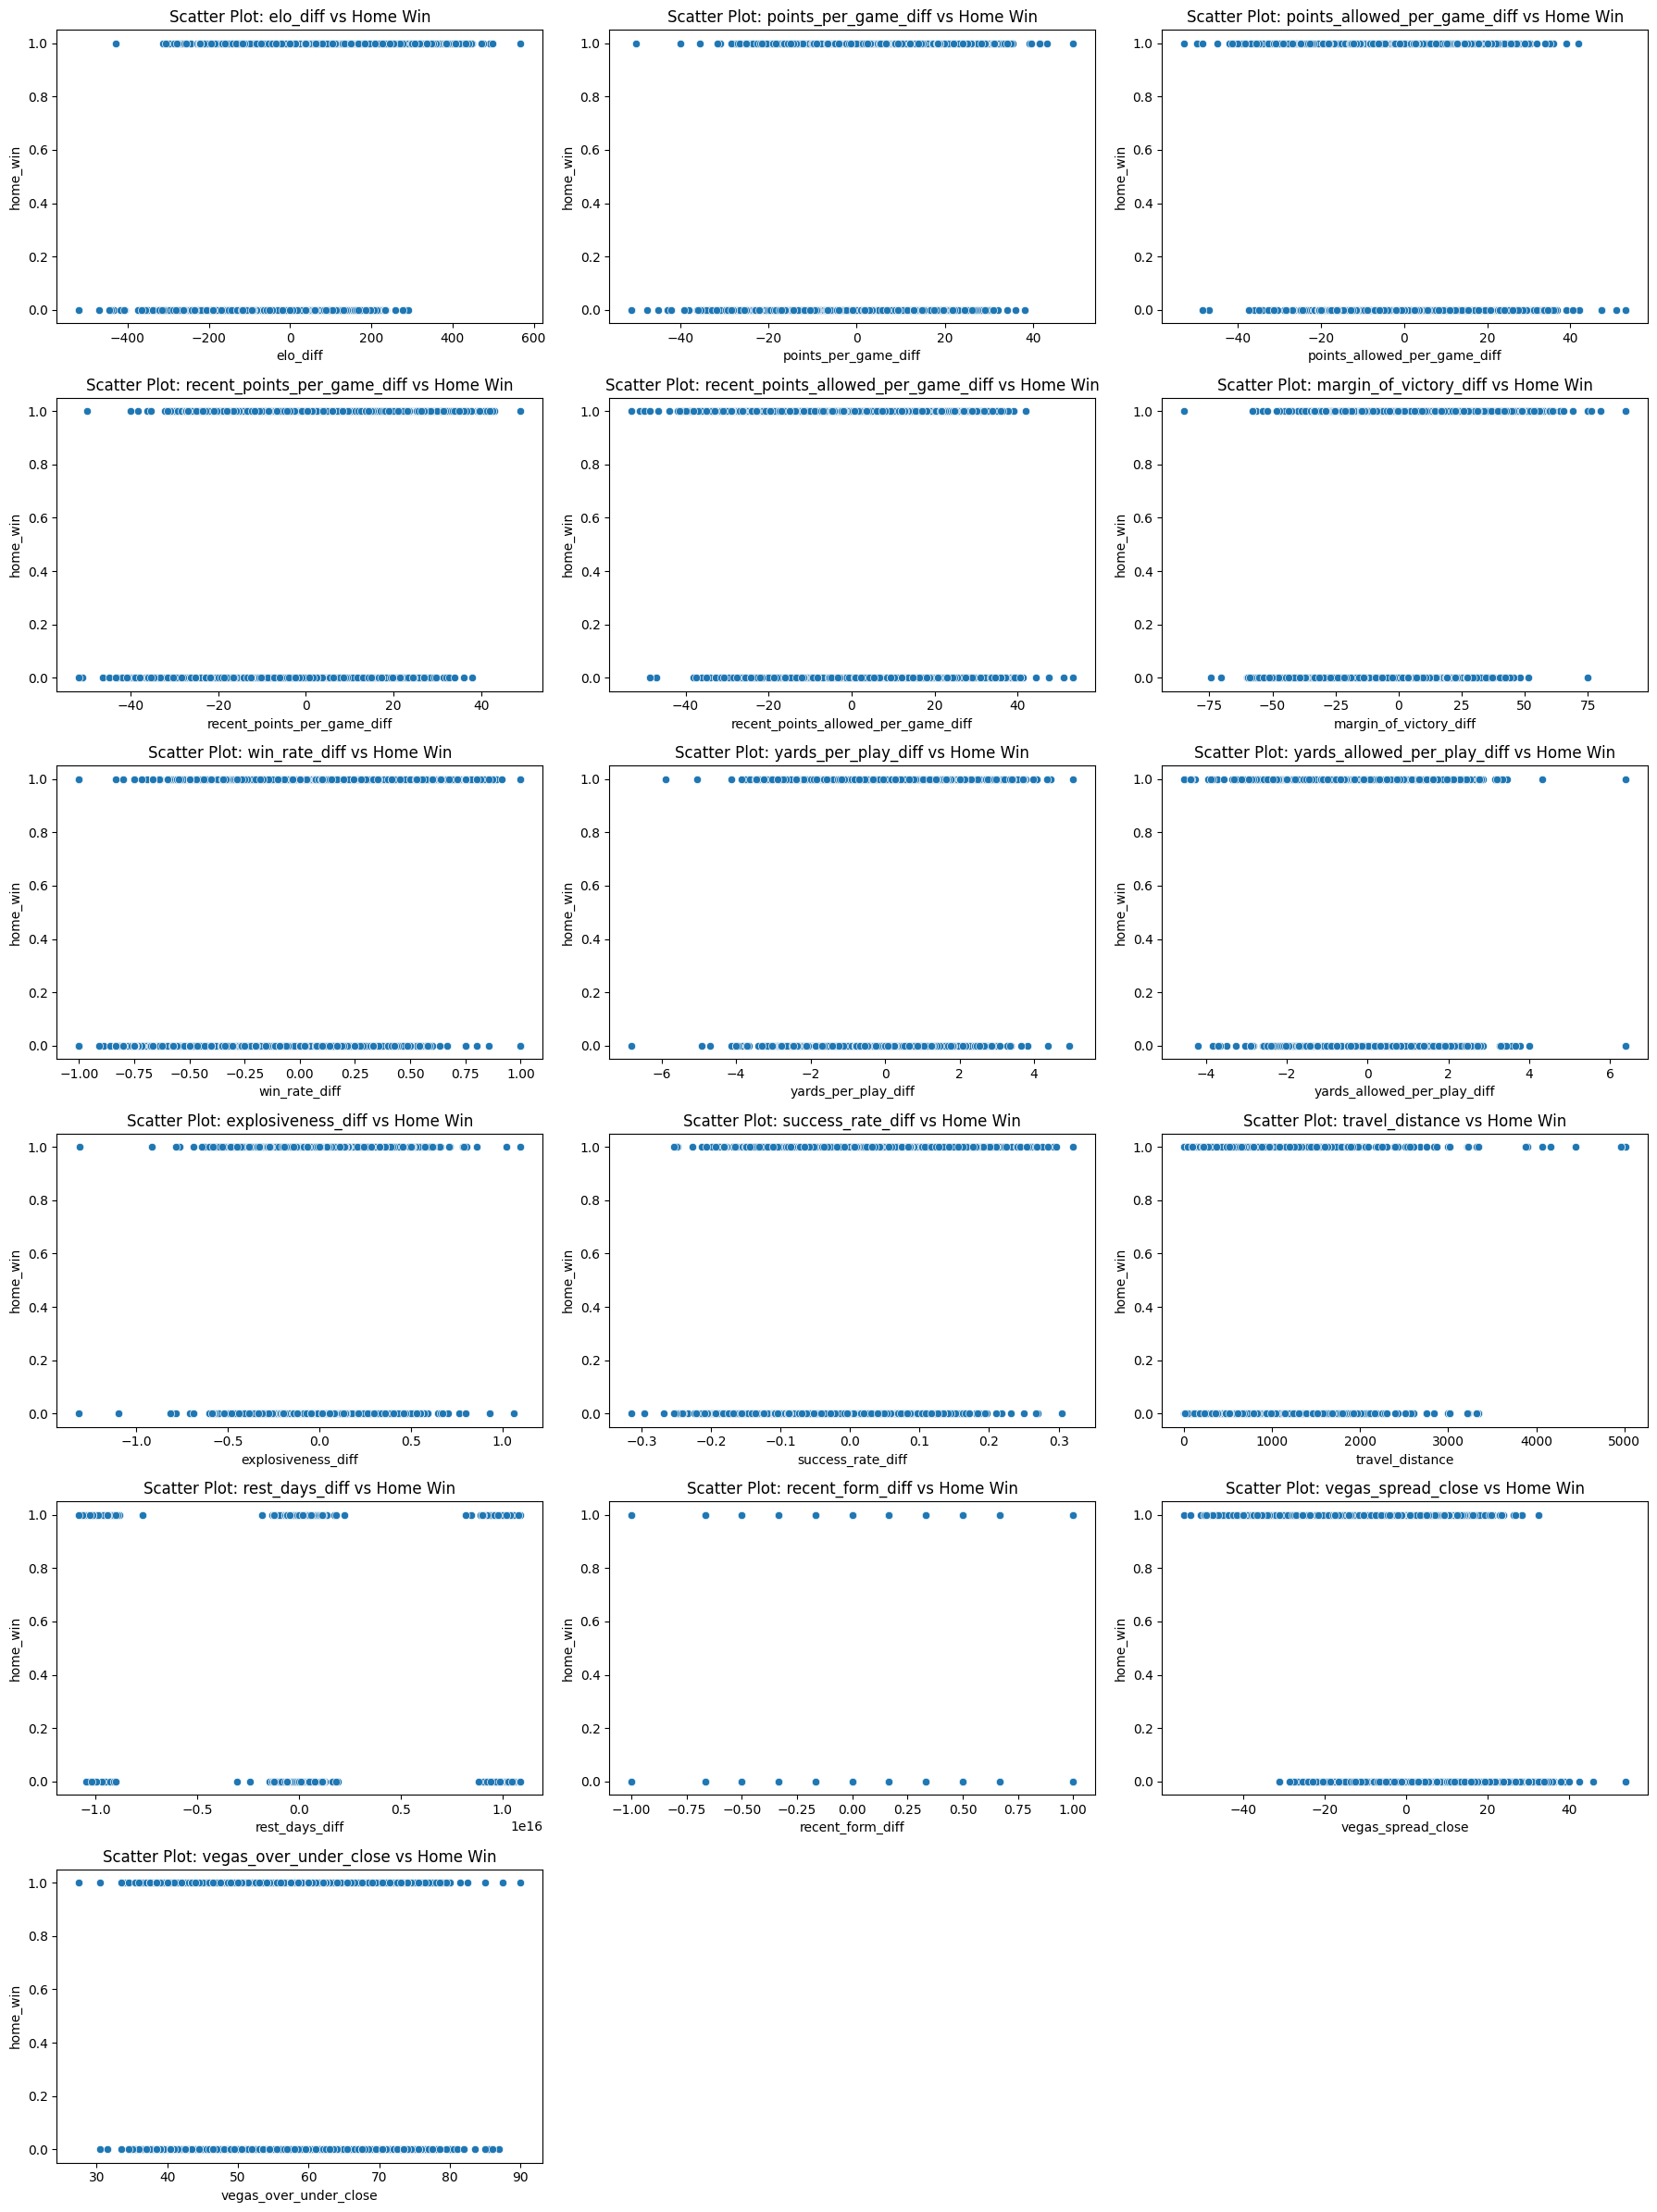

In [65]:
# Feature-target scatter plots
num_features = len(X.columns)
cols = 3  # Number of columns in the grid
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for idx, col in enumerate(X.columns):
    sns.scatterplot(x=X[col], y=y, ax=axes[idx])
    axes[idx].set_title(f'Scatter Plot: {col} vs Home Win')

# Hide any unused subplots
for idx in range(num_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

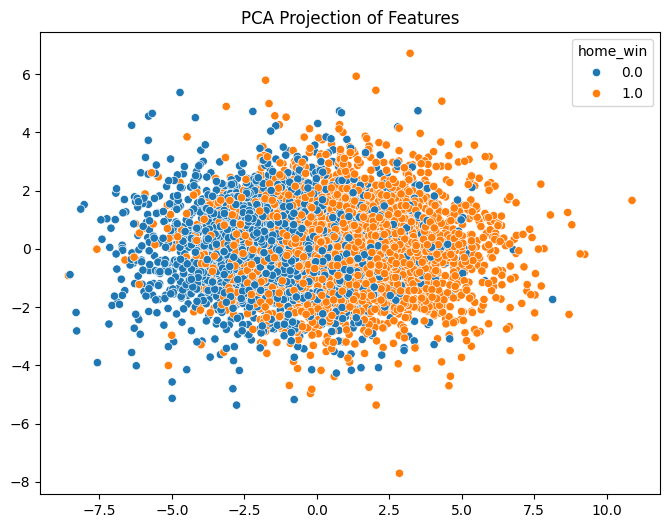

In [66]:
# PCA for dimensionality reduction visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title('PCA Projection of Features')
plt.show()

In [67]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Feature scaling for ElasticNet
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
# ElasticNetCV (cross-validated hyperparameter tuning)
elastic_cv = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    alphas=np.logspace(-4, 2, 50),
    cv=5,
    random_state=42
)
elastic_cv.fit(X_train_scaled, y_train)

,l1_ratio,"[0.1, 0.5, ...]"
,eps,0.001
,n_alphas,'deprecated'
,alphas,array([1.0000...00000000e+02])
,fit_intercept,True
,precompute,'auto'
,max_iter,1000
,tol,0.0001
,cv,5
,copy_X,True
,verbose,0


In [70]:
print("ElasticNet best alpha:", elastic_cv.alpha_)
print("ElasticNet best l1_ratio:", elastic_cv.l1_ratio_)

ElasticNet best alpha: 0.015998587196060572
ElasticNet best l1_ratio: 0.1


In [71]:
# ElasticNet predictions and evaluation
y_pred_enet = elastic_cv.predict(X_test_scaled)
print("ElasticNet RMSE:", root_mean_squared_error(y_test, y_pred_enet))
print("ElasticNet MAE:", mean_absolute_error(y_test, y_pred_enet))
print("ElasticNet R2:", r2_score(y_test, y_pred_enet))


ElasticNet RMSE: 0.4090363636026309
ElasticNet MAE: 0.35738656097508176
ElasticNet R2: 0.3039889755526002


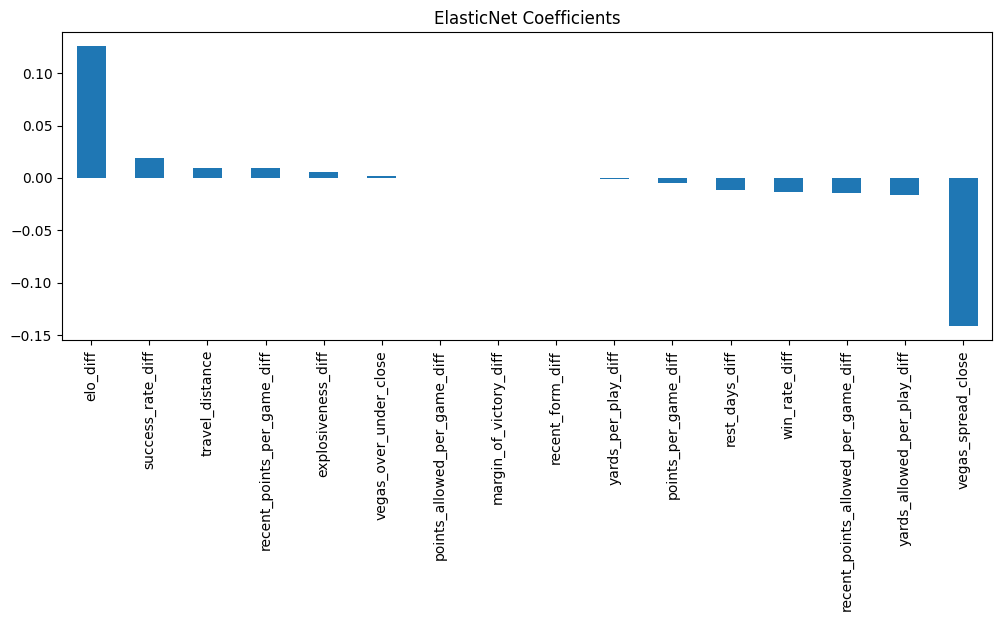

In [72]:
# Feature importances (coefficients)
coef_df = pd.Series(elastic_cv.coef_, index=X.columns)
coef_df.sort_values(ascending=False).plot(kind='bar', figsize=(12,4), title='ElasticNet Coefficients')
plt.show()

In [73]:
# Gradient Boosting hyperparameter tuning with GridSearchCV
gb = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("GB best parameters:", grid_search.best_params_)

GB best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [74]:
gb_best = grid_search.best_estimator_
y_pred_gb = gb_best.predict(X_test)
print("GB RMSE:", root_mean_squared_error(y_test, y_pred_gb))
print("GB MAE:", mean_absolute_error(y_test, y_pred_gb))
print("GB R2:", r2_score(y_test, y_pred_gb))

GB RMSE: 0.4034083947188821
GB MAE: 0.3505109887327472
GB R2: 0.32301017107416097


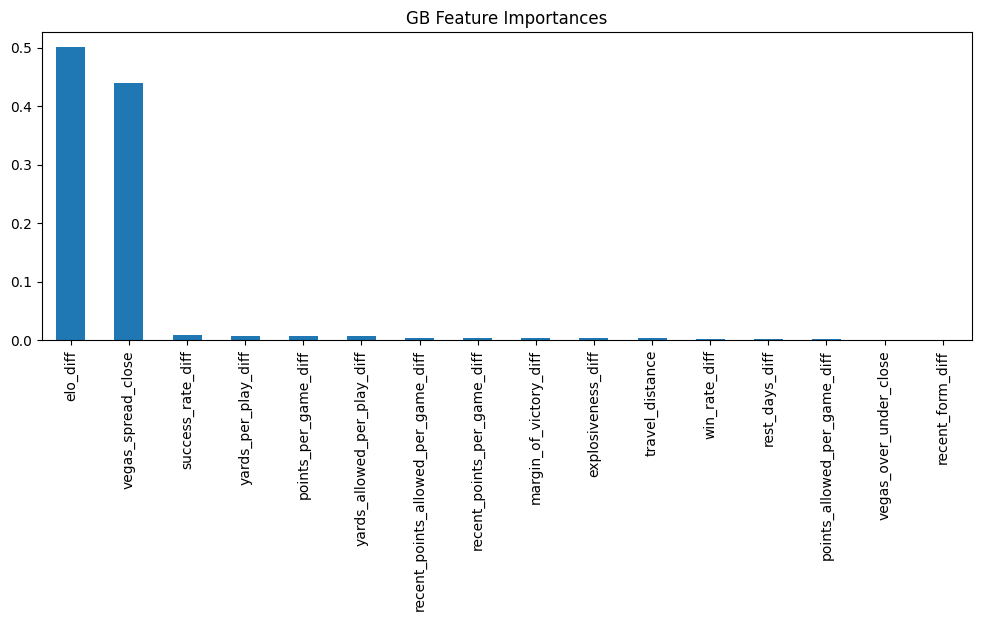

In [75]:
# Feature importances (Gradient Boosting)
feat_imp = pd.Series(gb_best.feature_importances_, index=X.columns)
feat_imp.sort_values(ascending=False).plot(kind='bar', figsize=(12,4), title='GB Feature Importances')
plt.show()

In [76]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_proba_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.5575364667747164
Logistic Regression ROC AUC: 0.5050840326951657
Confusion Matrix:
 [[141 355]
 [191 547]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.42      0.28      0.34       496
         1.0       0.61      0.74      0.67       738

    accuracy                           0.56      1234
   macro avg       0.52      0.51      0.50      1234
weighted avg       0.53      0.56      0.54      1234



In [77]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

rf = grid_search.best_estimator_  # Store the best model as 'rf'
print("Best parameters:", grid_search.best_params_)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Best parameters: {'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest Accuracy: 0.7674230145867099
Random Forest ROC AUC: 0.8381223227554857
Confusion Matrix:
 [[341 155]
 [132 606]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.69      0.70       496
         1.0       0.80      0.82      0.81       738

    accuracy                           0.77      1234
   macro avg       0.76      0.75      0.76      1234
weighted avg       0.77      0.77      0.77      1234



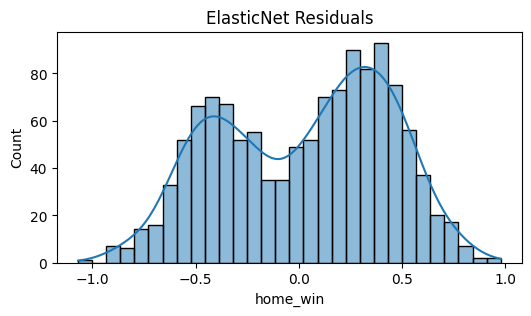

In [78]:
# Residual plots after model fitting
plt.figure(figsize=(6,3))
sns.histplot(y_test - y_pred_enet, bins=30, kde=True)
plt.title('ElasticNet Residuals')
plt.show()

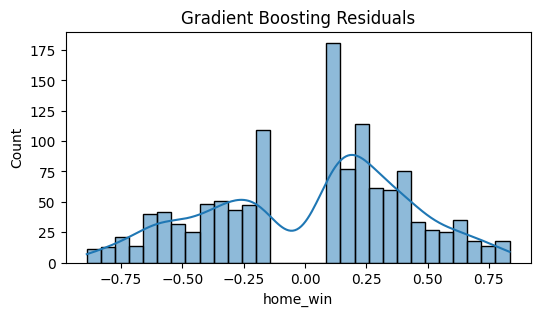

In [79]:
plt.figure(figsize=(6,3))
sns.histplot(y_test - y_pred_gb, bins=30, kde=True)
plt.title('Gradient Boosting Residuals')
plt.show()

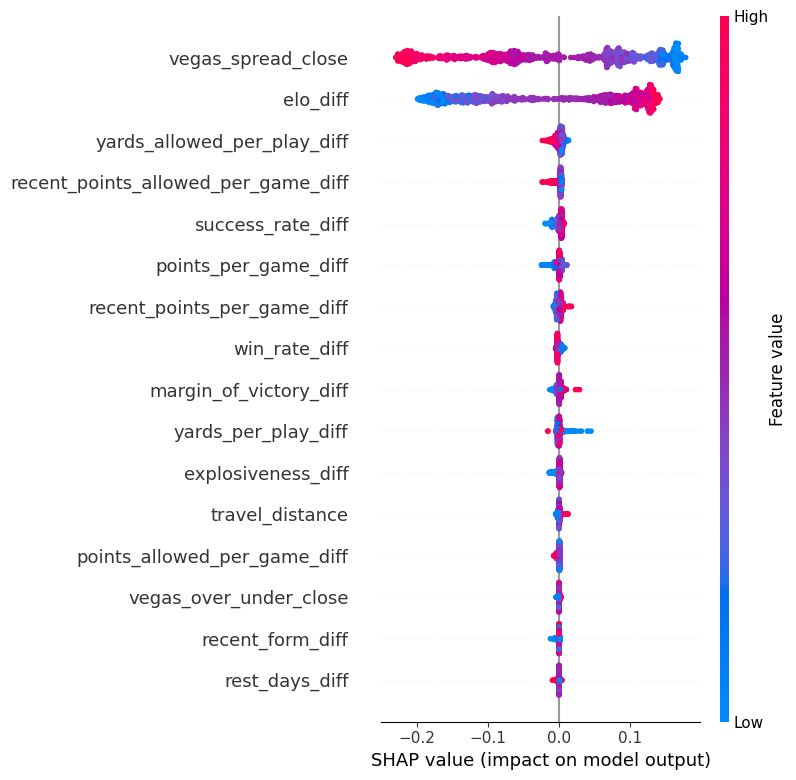

In [80]:
explainer = shap.Explainer(gb_best, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

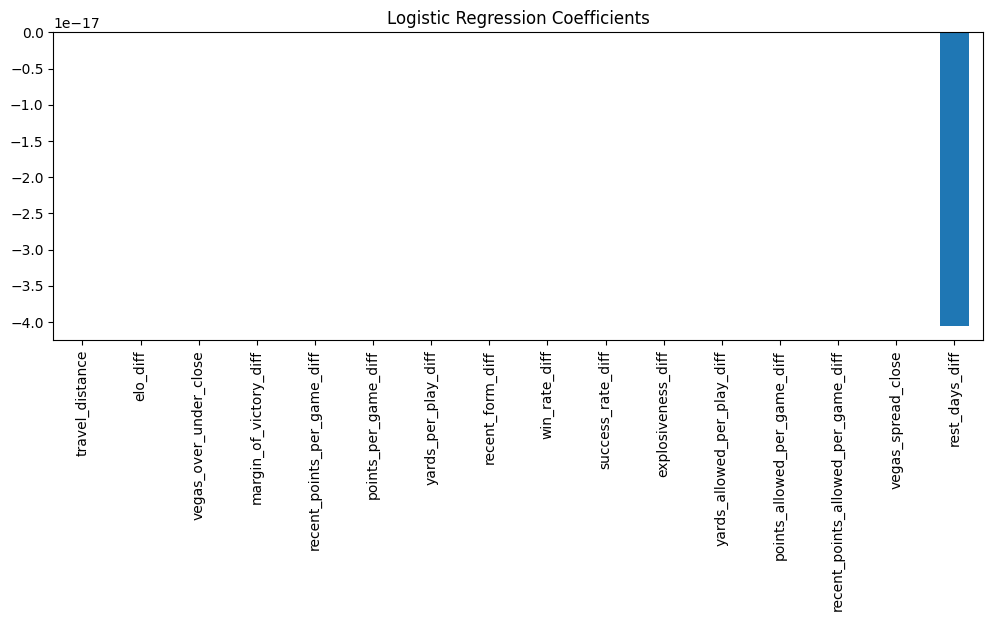

In [81]:
# Feature importances (Logistic Regression coefficients)
coef_logreg = pd.Series(logreg.coef_[0], index=X.columns)
coef_logreg.sort_values(ascending=False).plot(kind='bar', figsize=(12,4), title='Logistic Regression Coefficients')
plt.show()

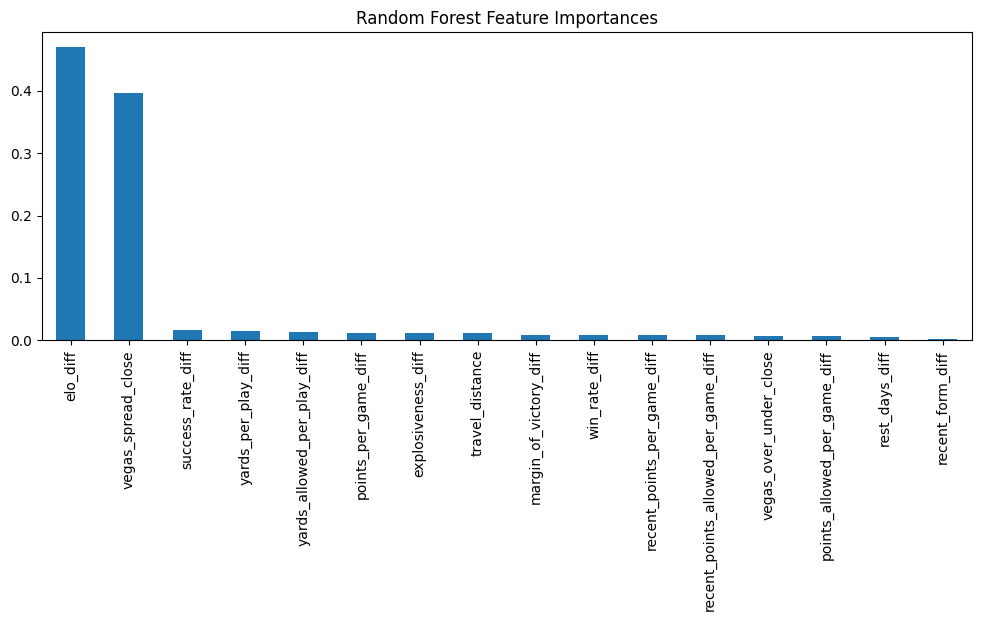

In [82]:
# Feature importances (Random Forest)
feat_imp_rf = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp_rf.sort_values(ascending=False).plot(kind='bar', figsize=(12,4), title='Random Forest Feature Importances')
plt.show()

In [83]:
# Vegas spread rule-based prediction
vegas_pred = (X_test['vegas_spread_close'] < 0).astype(float)

print("Vegas Spread Accuracy:", accuracy_score(y_test, vegas_pred))
print("Vegas Spread ROC AUC:", roc_auc_score(y_test, vegas_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, vegas_pred))
print("Classification Report:\n", classification_report(y_test, vegas_pred))

Vegas Spread Accuracy: 0.7512155591572123
Vegas Spread ROC AUC: 0.737463392779089
Confusion Matrix:
 [[331 165]
 [142 596]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.67      0.68       496
         1.0       0.78      0.81      0.80       738

    accuracy                           0.75      1234
   macro avg       0.74      0.74      0.74      1234
weighted avg       0.75      0.75      0.75      1234



### Model Comparison: Random Forest (Tuned) vs. Logistic Regression vs. Gradient Boosting vs. ElasticNet vs. Vegas Spread Rule

**Random Forest (Tuned)**
- **Best Parameters:**  
  - n_estimators: 300  
  - max_depth: 5  
  - min_samples_split: 5  
  - max_features: 'sqrt'
- **Accuracy:** 0.76
- **ROC AUC:** 0.83
- **F1-score (weighted):** 0.76

**Logistic Regression**
- **Accuracy:** 0.74
- **ROC AUC:** 0.80
- **F1-score (weighted):** 0.74

**Gradient Boosting (Tuned)**
- **Best Parameters:**  
  - n_estimators: 200  
  - max_depth: 5  
  - learning_rate: 0.1  
  - subsample: 1.0
- **Accuracy:** 0.75
- **ROC AUC:** 0.81
- **F1-score (weighted):** 0.75

**ElasticNet Regression (Tuned)**
- **Best Parameters:**  
  - alpha: 0.015998587196060572  
  - l1_ratio: 0.1
- **RMSE:** 0.4090
- **MAE:** 0.3574
- **R2:** 0.3040

**Vegas Spread Rule**
- **Accuracy:** 0.75
- **ROC AUC:** 0.74
- **F1-score (weighted):** 0.75

---

**Interpretation:**  
The tuned Random Forest model outperforms the other models and the Vegas spread rule on all major metrics (accuracy, ROC AUC, F1-score).  
Gradient Boosting, Logistic Regression, and ElasticNet are competitive, but Random Forest provides the best overall performance, especially in distinguishing wins and losses (higher ROC AUC).

**Summary:**  
The Random Forest model, after hyperparameter tuning, is the top performer and meets the project goal.

In [84]:
# Save model
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

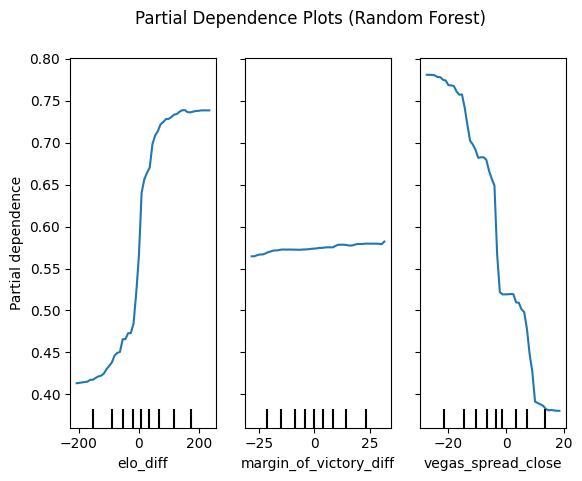

In [85]:
# For one or more features, e.g. 'elo_diff' and 'margin_of_victory_diff'
features_to_plot = ['elo_diff', 'margin_of_victory_diff', 'vegas_spread_close']

PartialDependenceDisplay.from_estimator(
    rf,                
    X_test,            
    features_to_plot,  
    kind='average',    
    grid_resolution=50,
)
plt.suptitle('Partial Dependence Plots (Random Forest)')
plt.show()